<a href="https://colab.research.google.com/github/LeeYuuuan/RBF-CNN-EIT/blob/main/CNN_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import package

In [ ]:
pip install torchsummary


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from scipy import io
import torch
from torch.utils.data import TensorDataset,DataLoader,Dataset
from torch.autograd import Variable 
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torchsummary
import time
import sys
sys.path.append(r"/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning")
sys.path.append(r"/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/data")
import torch_rbf as rbf

# Create Custom Dataset 

In [ ]:
class CustomEITDataSet(Dataset):
    """EIT simulation dataset"""
    def __init__(self, dataset_type):
        """
        Args:
            root_dfir: Directory with all the data.
        """  

        dic_path = "/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/data/"
        
        # load the .csv simulation data 
        # voltage_data = np.loadtxt(dic_path + 'datacsv1.csv', delimiter=';', dtype=np.float32)
        # label = np.loadtxt(dic_path + 'datacsv.csv', delimiter=';', dtype=np.float32)
        print(f"Loading {dataset_type}")
        print("Loading voltages...")

        
        time_0 = time.time()
        voltage_data = np.loadtxt(dic_path + 'data04.csv', delimiter=',', dtype=np.float32)
        time_1 = time.time() - time_0
        print(f"using {time_1}s.")
        print("Loading labels...")
        label = np.loadtxt(dic_path + 'data04R.csv', delimiter=',', dtype=np.float32)
        time_2 = time.time() - time_0
        print(f"Using {time_2}s.")
  
        # split train/test dataset
        print("Creating the dataset...")
        X_train_raw, X_test_raw, y_train, y_test = train_test_split(voltage_data, label, test_size=0.2, random_state=42)

        X_train = np.zeros([X_train_raw.shape[0], 1, 16, 12]) # shape: count * 1 * 16(angle) * 12(voltage)
        X_test = np.zeros([X_test_raw.shape[0], 1, 16, 12])

        for i, data_element in enumerate(X_train_raw):
            X_train[i, 0, :, :] = X_train_raw[i].reshape(16, 12)
        for i, data_element in enumerate(X_test_raw):
            X_test[i, 0, :, :] = X_test_raw[i].reshape(16,12)

        # return different type of data
        if dataset_type == 'train':
            self.x = X_train
            self.y = y_train
            self.len = X_train.shape[0]
            time_3 = time.time() - time_0
            print(f"Finished loading train set! Using{time_3}s.")
        elif dataset_type == 'test':
            self.x = X_test
            self.y = y_test
            self.len = X_test.shape[0]
            time_4 = time.time() - time_0
            print(f"Finished loading test set! Using{time_4}s.")
        else:
            raise ValueError

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

# Create CNN model

In [ ]:
class CNNnet(torch.nn.Module):
    def __init__(self, layer_widths, layer_centres, basis_func):
        super(CNNnet,self).__init__()
        self.rbf_layers = nn.ModuleList()
        self.linear_layers = nn.ModuleList()
        self.conv1_1 = nn.Sequential(
            # (1, 16, 12)pytorch输入不用定义大小，因为参数过多写成nn.Conv2d(1,64,3,1，1)形式容易出错，有的参数默认了
            nn.Conv2d(
                in_channels=1,#单通道
                out_channels=64,#64通道
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1#零填充
            ),
            torch.nn.BatchNorm2d(64),#批量归一化
            nn.ELU(),#ELU激活函数
        )
        self.conv1_2 = nn.Sequential(
            torch.nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(64),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2)#最大池化层，核大小为2
        )
        self.conv2_1 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(128),
            nn.ELU(),
        )
        self.conv2_2 = nn.Sequential(
            torch.nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(128),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3_1 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(256),
            nn.ELU(),
        )
        self.conv3_2 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=3,  
                stride=1,  
                padding=1
            ),
            torch.nn.BatchNorm2d(256),
            nn.ELU(),
        )
        self.conv3_3 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(256),
            nn.ELU(),
        )
        self.conv3_4 = nn.Sequential(
            torch.nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(256),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4_1 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(512),
            nn.ELU(),
        )
        self.conv4_2 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(512),
            nn.ELU(),
        )
        self.conv4_3 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(512),
            nn.ELU(),
        )
        self.conv4_4 = nn.Sequential(
            torch.nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(512),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=2,ceil_mode=True)#平均池化层，核大小为2，2×1经过这层变成1×0，报错，但有ceil_mode=True为向上取整，变成1×1
        )
        for i in range(len(layer_widths) - 1):
            self.rbf_layers.append(rbf.RBF(layer_widths[i], layer_centres[i], basis_func))
            self.linear_layers.append(nn.Linear(layer_centres[i], layer_widths[i + 1]))
        self.mlp2 = torch.nn.Linear(512,576) #输出层，512是输入这层的大小，576是输出的大小
    '''
    前向传播
    '''
    def forward(self, x):
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.conv3_4(x)
        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.conv4_4(x)
        
        x = x.view(x.size(0),-1)#四维数据（数据量，通道，纵向，横向），展开为二维（数据量，只有横向）
        
        for i in range(len(self.rbf_layers)):
            x = self.rbf_layers[i](x)
            x = self.linear_layers[i](x)
        x = self.mlp2(x)
        return x

# just CNN

In [ ]:
class CNNJustnet(torch.nn.Module):
    def __init__(self, layer_widths, layer_centres, basis_func):
        super(CNNJustnet,self).__init__()
        self.rbf_layers = nn.ModuleList()
        self.linear_layers = nn.ModuleList()
        self.conv1_1 = nn.Sequential(
            # (1, 16, 12)pytorch输入不用定义大小，因为参数过多写成nn.Conv2d(1,64,3,1，1)形式容易出错，有的参数默认了
            nn.Conv2d(
                in_channels=1,#单通道
                out_channels=64,#64通道
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1#零填充
            ),
            torch.nn.BatchNorm2d(64),#批量归一化
            nn.ELU(),#ELU激活函数
        )
        self.conv1_2 = nn.Sequential(
            torch.nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(64),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2)#最大池化层，核大小为2
        )
        self.conv2_1 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(128),
            nn.ELU(),
        )
        self.conv2_2 = nn.Sequential(
            torch.nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(128),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3_1 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(256),
            nn.ELU(),
        )
        self.conv3_2 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=3,  
                stride=1,  
                padding=1
            ),
            torch.nn.BatchNorm2d(256),
            nn.ELU(),
        )
        self.conv3_3 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(256),
            nn.ELU(),
        )
        self.conv3_4 = nn.Sequential(
            torch.nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(256),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4_1 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(512),
            nn.ELU(),
        )
        self.conv4_2 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(512),
            nn.ELU(),
        )
        self.conv4_3 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(512),
            nn.ELU(),
        )
        self.conv4_4 = nn.Sequential(
            torch.nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(512),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=2,ceil_mode=True)#平均池化层，核大小为2，2×1经过这层变成1×0，报错，但有ceil_mode=True为向上取整，变成1×1
        )
        self.mlp2 = torch.nn.Linear(512,576) #输出层，512是输入这层的大小，576是输出的大小
    '''
    前向传播
    '''
    def forward(self, x):
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.conv3_4(x)
        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.conv4_4(x)
        
        x = x.view(x.size(0),-1)#四维数据（数据量，通道，纵向，横向），展开为二维（数据量，只有横向）
        
        x = self.mlp2(x)
        return x

In [ ]:
model = 

# Load Data

In [ ]:
# Load dataset.
dataset_train = CustomEITDataSet('train')
train_loader = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)

dataset_test = CustomEITDataSet('test')  
test_loader = DataLoader(dataset=dataset_test, batch_size=32, shuffle=True)

Loading train
Loading voltages...
using 4.199032783508301s.
Loading labels...
Using 12.576471328735352s.
Creating the dataset...
Finished loading train set! Using12.973464488983154s.
Loading test
Loading voltages...
using 3.0633552074432373s.
Loading labels...
Using 10.438817739486694s.
Creating the dataset...
Finished loading test set! Using10.528818845748901s.


# Training model

## Set parameters

In [ ]:
layer_widths = [512] # 神经元数量
layer_centres = [40]
basis_func = rbf.gaussian # 初始偏置
learning_rt = 0.05
model = CNNnet(layer_widths, layer_centres, basis_func) # Model initialized
# print(model)
model = model.float() # parameters to float.
device = torch.device('cuda:0')
model.to(device) # 训练数据和模型数据类型要统一，并且pytorch-gpu数据类型要变成指定类型

loss_func = torch.nn.MSELoss() # loss function: MSE
opt = torch.optim.SGD(model.parameters(), lr=learning_rt, momentum=0.9) # gradient descent with momentum
# opt = torch.optim.Adam(model.parameters(), lr=learning_rt)
opt_type = "SDG"

'''
下面矩阵存放训练过程中损失函数等数据
'''


'\n下面矩阵存放训练过程中损失函数等数据\n'

In [ ]:
#cpu版本
layer_widths = [512] # 神经元数量
layer_centres = [40]
basis_func = rbf.gaussian # 初始偏置
learning_rt = 0.05
model = CNNnet(layer_widths, layer_centres, basis_func) # Model initialized
# print(model)
model = model.float() # parameters to float.
device = torch.device('cpu')
model.to(device) # 训练数据和模型数据类型要统一，并且pytorch-gpu数据类型要变成指定类型

loss_func = torch.nn.MSELoss() # loss function: MSE
opt = torch.optim.SGD(model.parameters(), lr=learning_rt, momentum=0.9) # gradient descent with momentum
# opt = torch.optim.Adam(model.parameters(), lr=learning_rt)
opt_type = "SDG"

## Train Model

## for test


In [ ]:
np.average([1,2,2,2,2])

1.8

## org


In [ ]:
loss_count = []
train_iter_loss = []
test_iter_loss = []
epochs=100 #轮数
for epoch in range(epochs):
    batch_loss = []
    test_loss = []
    for i, (x, y)in enumerate(train_loader):
      
        batch_x = Variable(x).to(torch.float32) # torch.Size([, 1, 16, 12])
        batch_x = batch_x.cuda()
        batch_y = Variable(y).to(torch.float32) # torch.Size([576])
        batch_y = batch_y.cuda()
        out = model(batch_x)        # 获取最后输出
        loss = loss_func(out, batch_y)        # 获取损失
        batch_loss.append(loss.cuda().data.cpu().numpy())    # 使用优化器优化损失
        opt.zero_grad()  # 清空上一步残余更新参数值
        loss.backward() # 误差反向传播，计算参数更新值
        opt.step() # 将参数更新值施加到net的parmeters上
    
        '''
        每20个数据显示一次训练集均方误差
        '''
        """
        if i%20 == 0:
            loss_count.append(loss)
            print('train MSE {}:\t'.format(i), loss.item())
            # torch.save(model, '/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/model')
        """
    train_iter_loss.append(np.average(np.array(batch_loss)))
    for a,b in test_loader:
        
        test_x = Variable(a).to(torch.float32)
        test_x = test_x.cuda()
        test_y = Variable(b).to(torch.float32)
        test_y = test_y.cuda()
        out = model(test_x)
        loss = loss_func(out, test_y)
        test_loss.append(loss.cuda().data.cpu().numpy())
        '''
        每轮示一次测试集均方误差
        '''
        # print('test MSE {}:\t'.format(epoch+1), loss.item())
    test_iter_loss.append(np.average(np.array(test_loss)))
    print('test MSE {}:\t'.format(epoch+1), test_iter_loss[epoch],end='')
    print('train MSE {}:\t'.format(epoch+1), train_iter_loss[epoch])
    

'''
绘制测试集 轮数与均方误差图像
'''
x = np.arange(epochs)
y = np.array(test_iter_loss) / 32
plt.plot(x, y)

plt.title('pic')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/lossfg/test_loss_{learning_rt}_{opt_type}.png',dpi=600, bbox_inches='tight')
plt.show()

torch.save(model, f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/model/model_{learning_rt}_{opt_type}.pth')

np.save(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/loss/train_iter_loss_{learning_rt}_{opt_type}.npy', np.array(train_iter_loss) / 32)
np.save(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/loss/test_iter_loss_{learning_rt}_{opt_type}.npy', np.array(test_iter_loss) / 32)
# np.save(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/loss/test_loss_{learning_rt}_{opt_type}.npy', test_loss)


## cpu


In [ ]:
loss_count = []
train_iter_loss = []
test_iter_loss = []
epochs=100 #轮数
for epoch in range(epochs):
    batch_loss = []
    test_loss = []
    for i, (x, y)in enumerate(train_loader):
      
        batch_x = Variable(x).to(torch.float32) # torch.Size([, 1, 16, 12])

        batch_y = Variable(y).to(torch.float32) # torch.Size([576])

        out = model(batch_x)        # 获取最后输出
        loss = loss_func(out, batch_y)        # 获取损失
        batch_loss.append(loss.data.cpu().numpy())    # 使用优化器优化损失
        opt.zero_grad()  # 清空上一步残余更新参数值
        loss.backward() # 误差反向传播，计算参数更新值
        opt.step() # 将参数更新值施加到net的parmeters上
    
        '''
        每20个数据显示一次训练集均方误差
        '''
        """
        if i%20 == 0:
            loss_count.append(loss)
            print('train MSE {}:\t'.format(i), loss.item())
            # torch.save(model, '/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/model')
        """
    train_iter_loss.append(np.average(np.array(batch_loss)))
    for a,b in test_loader:
        
        test_x = Variable(a).to(torch.float32)
        test_x = test_x
        test_y = Variable(b).to(torch.float32)
        test_y = test_y
        out = model(test_x)
        loss = loss_func(out, test_y)
        test_loss.append(loss.data.cpu().numpy())
        '''
        每轮示一次测试集均方误差
        '''
        # print('test MSE {}:\t'.format(epoch+1), loss.item())
    test_iter_loss.append(np.average(np.array(test_loss)))
    print('test MSE {}:\t'.format(epoch+1), test_iter_loss[epoch],end='')
    print('train MSE {}:\t'.format(epoch+1), train_iter_loss[epoch])
    

'''
绘制测试集 轮数与均方误差图像
'''
x = np.arange(epochs)
y = np.array(test_iter_loss) / 32
plt.plot(x, y)

plt.title('pic')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/lossfg/test_loss_{learning_rt}_{opt_type}.png',dpi=600, bbox_inches='tight')
plt.show()

torch.save(model, f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/model/model_{learning_rt}_{opt_type}.pth')

np.save(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/loss/train_iter_loss_{learning_rt}_{opt_type}.npy', np.array(train_iter_loss) / 32)
np.save(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/loss/test_iter_loss_{learning_rt}_{opt_type}.npy', np.array(test_iter_loss) / 32)
# np.save(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/loss/test_loss_{learning_rt}_{opt_type}.npy', test_loss)


test MSE 1:	 0.0020176354train MSE 1:	 0.0035697094
test MSE 2:	 0.0020177944train MSE 2:	 0.0020083021
test MSE 3:	 0.0020114095train MSE 3:	 0.0020064125


KeyboardInterrupt: ignored

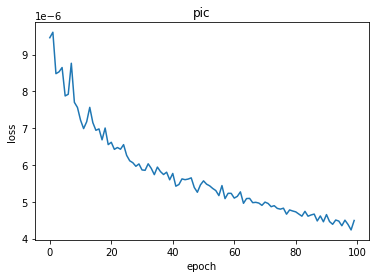

In [ ]:
x = np.arange(epochs)
y = np.array(test_iter_loss) / 32
plt.plot(x, y)
plt.title('pic')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/lossfg/test_loss_{learning_rt}_{opt_type}.png',dpi=600, bbox_inches='tight')
plt.show()
np.save(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/loss/train_iter_loss_{learning_rt}_{opt_type}.npy', np.array(train_iter_loss) / 32)
np.save(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/loss/test_iter_loss_{learning_rt}_{opt_type}.npy', np.array(test_iter_loss) / 32)
# np.save(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/loss/test_loss_{learning_rt}_{opt_type}.npy', test_loss)



# Load model

## Adam model.

### lr = 0.0005

In [ ]:
model = torch.load('/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/model/model_0.0005_Adam.pth', map_location=torch.device('cpu'))

### lr = 0.001

In [ ]:
model = torch.load('/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/model/model_0.001_Adam.pth',  map_location=torch.device('cpu'))

### lr = 0.0001

In [ ]:
model = torch.load('/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/model/model_0.0001_Adam.pth', map_location=torch.device('cpu'))

## SDG model

### lr = 0.01

In [ ]:
model = torch.load('/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/model/model_0.01_SDG.pth', map_location=torch.device('cpu'))

In [ ]:
model = torch.load('/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/model/model_0.001_SDG.pth', map_location=torch.device('cpu'))

### 0.0001

In [ ]:
model = torch.load('/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/model/model_0.0001_SDG.pth', map_location=torch.device('cpu'))

## lr = 0.1

In [ ]:
model = torch.load('/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/model/model_0.1_SDG.pth')

## CNNJust

### lr = 

In [ ]:
model = torch.load('/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/model/model_0.0005_Adam_JUST.pth', map_location=torch.device('cpu'))

In [ ]:
model = torch.load('/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/model/model_0.001_SDG_JUST.pth', map_location=torch.device('cpu'))

# Forward for getting elements R.

In [ ]:
# pre batch
dataiter = iter(test_loader)
vol, re_batch = next(dataiter)
pre = model.forward(Variable(vol).to(torch.float32))
re.shape
# (pre[0].cpu() - re[0])

torch.Size([32, 576])

In [ ]:
pre_batch = model.forward(Variable(vol).to(torch.float32))
re = re_batch[0:4].numpy()
pre = pre_batch[0:4].detach().numpy()

In [ ]:
learning_rt = 0.001
opt_type = "Adam"
# save all for a certain time
for i in range(len(re)):
    np.save(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/pre_r_and_r/npy/pre_{learning_rt}_{opt_type}_00{i}.npy', pre[i])
    np.save(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/pre_r_and_r/npy/re_{learning_rt}_{opt_type}_00{i}.npy', re[i])
    mat_pre = np.load(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/pre_r_and_r/npy/pre_{learning_rt}_{opt_type}_00{i}.npy')
    io.savemat(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/pre_r_and_r/mat/pre_{learning_rt}_{opt_type}_00{i}.mat',{'mat_pre':mat_pre})

    mat_re = np.load(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/pre_r_and_r/npy/re_{learning_rt}_{opt_type}_00{i}.npy')
    io.savemat(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/pre_r_and_r/mat/re_{learning_rt}_{opt_type}_00{i}.mat', {'mat_re':mat_re})


In [ ]:
# save example!
np.save(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/testexample/pre.npy', pre)
np.save(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/testexample/re', re)

### 批处理

In [ ]:
v_bond_list = []
con_list = []
count = 0
for v_bond, con in test_loader:
    v_bond_list.append(v_bond)
    con_list.append(con[0])
    count += 1
    if count >= 4:
        break;
    

In [ ]:
v_bond_list[0].shape

torch.Size([32, 1, 16, 12])

In [ ]:
#cpu
pre = []
re = []
for i in range(len(v_bond_list)):
    pre_batch = model.forward(Variable(v_bond).to(torch.float32))
    pre.append(pre_batch[0].cpu().detach().numpy())
    re.append(con_list[i].numpy())

4

In [ ]:
# pre all same for same R
pre = []
re = []
for i in range(len(v_bond_list)):
    pre_batch = model.forward(Variable(v_bond).to(torch.float32).cuda())
    pre.append(pre_batch[0].cpu().detach().numpy())
    re.append(con_list[i][0].numpy())


576

#### no used

In [ ]:
# pre all
pre = []
re = []
count = 0
for v_bond, con in test_loader:
    pre_batch = model.forward(Variable(v_bond).to(torch.float32).cuda())
    pre.append(pre_batch[0].cpu().detach().numpy())
    re.append(con[0].numpy())
    count += 1
    if count >= 4:
        break
print(count)

4


### save

In [ ]:
# save all for a certain time
for i in range(len(re)):
    np.save(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/pre_r_and_r/npy/pre_{learning_rt}_{opt_type}_00{i}.npy', pre[i])
    np.save(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/pre_r_and_r/npy/re_{learning_rt}_{opt_type}_00{i}.npy', re[i])
    mat_pre = np.load(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/pre_r_and_r/npy/pre_{learning_rt}_{opt_type}_00{i}.npy')
    io.savemat(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/pre_r_and_r/mat/pre_{learning_rt}_{opt_type}_00{i}.mat',{'mat_pre':mat_pre})

    mat_re = np.load(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/pre_r_and_r/npy/re_{learning_rt}_{opt_type}_00{i}.npy')
    io.savemat(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/pre_r_and_r/mat/re_{learning_rt}_{opt_type}_00{i}.mat', {'mat_re':mat_re})


In [ ]:
output_re = re[10000].numpy()
output_pre = pre[10000].cpu().detach().numpy()

torch.Size([32, 576])

In [ ]:
output_pre

In [ ]:
i = 1
np.save(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/pre_r_and_r/npy/pre_{learning_rt}_{opt_type}_00{i}.npy', output_pre)
np.save(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/pre_r_and_r/npy/re_{learning_rt}_{opt_type}_00{i}.npy', output_re)


In [ ]:
mat_pre = np.load(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/pre_r_and_r/npy/pre_{learning_rt}_{opt_type}_00{i}.npy')
io.savemat(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/pre_r_and_r/mat/pre_{learning_rt}_{opt_type}_00{i}.mat',{'mat_pre':mat_pre})

mat_re = np.load(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/pre_r_and_r/npy/re_{learning_rt}_{opt_type}_00{i}.npy')
io.savemat(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/pre_r_and_r/mat/re_{learning_rt}_{opt_type}_00{i}.mat', {'mat_re':mat_re})

In [ ]:
torch.save(re, 're.pt')
torch.save(pre, 'pre.pt')

# Summarize the model

In [ ]:
def model_summary(model):
    """summarize the CNN model"""
    torchsummary.summary(model, input_size=(1, 16, 12))

In [ ]:
model = CNNnet([512], [40], rbf.gaussian)

In [ ]:
device = torch.device('cuda:0')
model.to(device) # 训练数据和模型数据类型要统一，并且pytorch-gpu数据类型要变成指定类型
model_summary(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 12]             640
       BatchNorm2d-2           [-1, 64, 16, 12]             128
               ELU-3           [-1, 64, 16, 12]               0
            Conv2d-4           [-1, 64, 16, 12]          36,928
       BatchNorm2d-5           [-1, 64, 16, 12]             128
               ELU-6           [-1, 64, 16, 12]               0
         MaxPool2d-7             [-1, 64, 8, 6]               0
            Conv2d-8            [-1, 128, 8, 6]          73,856
       BatchNorm2d-9            [-1, 128, 8, 6]             256
              ELU-10            [-1, 128, 8, 6]               0
           Conv2d-11            [-1, 128, 8, 6]         147,584
      BatchNorm2d-12            [-1, 128, 8, 6]             256
              ELU-13            [-1, 128, 8, 6]               0
        MaxPool2d-14            [-1, 12

# draw loss after stop

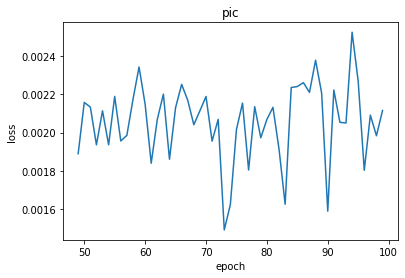

In [ ]:
x = np.arange(epochs)
# y = np.array(iter_loss)
y = np.array(test_iter_loss)
plt.plot(x[49:100], y[49: 100])
plt.title('pic')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/lossfg/test_loss_{learning_rt}_{opt_type}.png',dpi=600, bbox_inches='tight')
plt.show()



## no use

In [ ]:
np.save(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/loss/iter_loss_{learning_rt}_{opt_type}.npy', iter_loss)
np.save(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/loss/batch_loss_{learning_rt}_{opt_type}.npy', batch_loss)
np.save(f'/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/loss/test_loss_{learning_rt}_{opt_type}.npy', test_loss)


## no use

In [ ]:
"""test
"""
layer_widths = [512] # 神经元数量
layer_centres = [40]
basis_func = rbf.gaussian # 初始偏置

model = CNNnet(layer_widths, layer_centres, basis_func) # Model initialized
model = model.float() # parameters to float.
device = torch.device('cuda:0')
model.to(device) # 训练数据和模型数据类型要统一，并且pytorch-gpu数据类型要变成指定类型